In [325]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import metrics, linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import datetime, warnings, scipy 

In [248]:
path = '/home/jewelle/data_bootcamp/'
flights_df =  pd.read_csv(path +'flights_sub.csv', parse_dates=['fl_date'])
flights_df.head()

,Unnamed: 0,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,0,2018-01-23,UA,UA_CODESHARE,UA,3405,YX,N653RW,3405,10821,...,169.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2018-11-15,AA,AA_CODESHARE,AA,5683,OH,N594NN,5683,11057,...,640.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2019-10-29,WN,WN,WN,2434,WN,N432WN,2434,12889,...,867.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2019-11-14,B6,B6,B6,577,B6,N968JT,577,11697,...,2584.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2019-05-22,DL,DL_CODESHARE,DL,3762,OO,N8933B,3762,10397,...,508.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [249]:
dt_col = ['crs_dep_time', 'dep_time', 'crs_arr_time', 'arr_time', 'wheels_off', 'wheels_on']

In [250]:
def convert_time(x):
    if np.isnan(x):
        return '00:00'
    
    if x == 2400:
        return '23:59'   
    string = str(int(x))
    
    if len(string)< 4:
        for _ in range(4-len(string)):
            string = '0' + string
    
    return string[:2] + ':' + string[2:]

In [251]:
#run convert_time
flights_df['crs_dep_time'] = flights_df['crs_dep_time'].apply(lambda x: convert_time(x))
flights_df['crs_dep_time'] = pd.to_datetime(flights_df['crs_dep_time'], format = '%H:%M')

flights_df['dep_time'] = flights_df['dep_time'].apply(lambda x: convert_time(x))
flights_df['dep_time'] = pd.to_datetime(flights_df['dep_time'], format = '%H:%M')
flights_df['dep_hour'] = flights_df['dep_time'].dt.hour

flights_df['crs_arr_time'] = flights_df['crs_arr_time'].apply(lambda x: convert_time(x))
flights_df['crs_arr_time'] = pd.to_datetime(flights_df['crs_arr_time'], format = '%H:%M')

flights_df['arr_time'] = flights_df['arr_time'].apply(lambda x: convert_time(x))
flights_df['arr_time'] = pd.to_datetime(flights_df['arr_time'], format = '%H:%M')
flights_df['arr_hour'] = flights_df['arr_time'].dt.hour

flights_df['wheels_off'] = flights_df['wheels_off'].apply(lambda x: convert_time(x))
flights_df['wheels_off'] = pd.to_datetime(flights_df['wheels_off'], format = '%H:%M')

flights_df['wheels_on'] = flights_df['wheels_on'].apply(lambda x: convert_time(x))
flights_df['wheels_on'] = pd.to_datetime(flights_df['wheels_on'], format = '%H:%M')

In [252]:
flights_df.drop(['Unnamed: 0', 'mkt_unique_carrier', 'dup', 'no_name'], axis=1, inplace=True)

In [253]:
#check for missing values
total = flights_df.isnull().sum().sort_values(ascending=False)
percent = (flights_df.isnull().sum()/flights_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
longest_add_gtime,9928,0.9928
total_add_gtime,9928,0.9928
first_dep_time,9928,0.9928
cancellation_code,9828,0.9828
nas_delay,8140,0.8140


In [254]:
#drop columns with mostly missing data
drop_columns = missing_data[missing_data['Percent'] > 0.82].index.tolist()
flights_df.drop(drop_columns, axis=1, inplace=True)

In [255]:
flights_df.dropna(subset=['air_time', 'actual_elapsed_time', 'taxi_in', 'taxi_out'], inplace=True)

In [256]:
float_cols = flights_df.columns[flights_df.dtypes=='float64']
flights_df[float_cols] = flights_df[float_cols].fillna('0.0')
flights_df.fillna(0,inplace=True)

In [257]:
flights_df[['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
            'late_aircraft_delay', 'arr_delay', 'dep_delay']] = flights_df[['carrier_delay', 'weather_delay', 
                                                                            'nas_delay', 'security_delay', 
                                                                            'late_aircraft_delay', 'arr_delay', 
                                                                            'dep_delay']].apply(pd.to_numeric)

In [258]:
flights_df.head()

,fl_date,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,...,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,dep_hour,arr_hour
0,2018-01-23,UA_CODESHARE,UA,3405,YX,N653RW,3405,10821,BWI,"Baltimore, MD",...,49.0,1.0,169.0,0.0,0.0,0.0,0.0,0.0,5,7
1,2018-11-15,AA_CODESHARE,AA,5683,OH,N594NN,5683,11057,CLT,"Charlotte, NC",...,99.0,1.0,640.0,0.0,0.0,0.0,0.0,0.0,9,10
2,2019-10-29,WN,WN,2434,WN,N432WN,2434,12889,LAS,"Las Vegas, NV",...,139.0,1.0,867.0,0.0,0.0,0.0,0.0,0.0,21,23
3,2019-11-14,B6,B6,577,B6,N968JT,577,11697,FLL,"Fort Lauderdale, FL",...,346.0,1.0,2584.0,0.0,0.0,0.0,0.0,0.0,8,11
4,2019-05-22,DL_CODESHARE,DL,3762,OO,N8933B,3762,10397,ATL,"Atlanta, GA",...,73.0,1.0,508.0,0.0,0.0,0.0,0.0,0.0,14,15


#### Feature Engineering

* weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
* statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
* airports encoding: we need to think about what to do with the airports and other categorical variables
* time of the day: the delay probably depends on the airport traffic which varies during the day.
* airport traffic
* unsupervised learning as feature engineering?

what are the additional options?: Think about what we could do more to improve the model.

In [259]:
flights_df['delayed'] = flights_df['arr_delay'].apply(lambda x: x > 0)
flights_df['delayed'] = flights_df['delayed'].astype(int)

In [260]:
def haul_distance(x):
    if x < 2600:
        return 'SHORT'
    elif x >= 2600 and x < 3000:
        return 'MEDIUM'
    elif x >= 3000:
        return 'LONG'

In [261]:
flights_df['haul'] = flights_df['distance'].apply(lambda x: haul_distance(x))

In [262]:
flights_df['month'] = flights_df['fl_date'].dt.month

In [263]:
flights_df["season"] = "winter"
flights_df.loc[flights_df["month"].between(3,5), "season"] = "spring"
flights_df.loc[flights_df["month"].between(6,8), "season"] = "summer"
flights_df.loc[flights_df["month"].between(9,11), "season"] = "autumn"

In [264]:
flights_df["dep_time_of_the_day"] = "night"
flights_df.loc[flights_df["dep_hour"].between(6,11), "dep_time_of_the_day"] = "morning"
flights_df.loc[flights_df["dep_hour"].between(12,17), "dep_time_of_the_day"] = "afternoon"
flights_df.loc[flights_df["dep_hour"].between(18,21), "dep_time_of_the_day"] = "evening"

In [265]:
flights_df.select_dtypes(include=['object'])

,branded_code_share,mkt_carrier,op_unique_carrier,tail_num,origin,origin_city_name,dest,dest_city_name,haul,season,dep_time_of_the_day
0,UA_CODESHARE,UA,YX,N653RW,BWI,"Baltimore, MD",EWR,"Newark, NJ",SHORT,winter,night
1,AA_CODESHARE,AA,OH,N594NN,CLT,"Charlotte, NC",LIT,"Little Rock, AR",SHORT,autumn,morning
2,WN,WN,WN,N432WN,LAS,"Las Vegas, NV",SEA,"Seattle, WA",SHORT,autumn,evening
3,B6,B6,B6,N968JT,FLL,"Fort Lauderdale, FL",SFO,"San Francisco, CA",SHORT,autumn,morning
4,DL_CODESHARE,DL,OO,N8933B,ATL,"Atlanta, GA",FWA,"Fort Wayne, IN",SHORT,spring,afternoon
...,...,...,...,...,...,...,...,...,...,...,...
9994,DL_CODESHARE,DL,G7,N376CA,PIT,"Pittsburgh, PA",DTW,"Detroit, MI",SHORT,winter,evening
9995,WN,WN,WN,N789SW,DEN,"Denver, CO",OAK,"Oakland, CA",SHORT,spring,afternoon
9996,WN,WN,WN,N903WN,SNA,"Santa Ana, CA",LAS,"Las Vegas, NV",SHORT,spring,afternoon
9998,DL_CODESHARE,DL,9E,N935XJ,LGA,"New York, NY",CLT,"Charlotte, NC",SHORT,summer,afternoon


In [266]:
#Try label encoding?
lb_make = LabelEncoder()
flights_df["dest_code"] = lb_make.fit_transform(flights_df["dest"])
flights_df[["dest", "dest_code"]].head()

flights_df["carrier_code"] = lb_make.fit_transform(flights_df["mkt_carrier"])
flights_df[["mkt_carrier", "carrier_code"]].head()

flights_df['unique_carrier_code'] = lb_make.fit_transform(flights_df['op_unique_carrier'])
flights_df[['op_unique_carrier', 'unique_carrier_code']].head()

flights_df['origin_code'] = lb_make.fit_transform(flights_df['origin'])
flights_df[['origin', 'origin_code']].head()

,origin,origin_code
0,BWI,46
1,CLT,58
2,LAS,158
3,FLL,107
4,ATL,16


In [267]:
#one-hot encoding
cat_cols = ['haul', 'season', 'dep_time_of_the_day']
df_cat = pd.get_dummies(flights_df[cat_cols])

In [268]:
flights_df = pd.concat([flights_df, df_cat], axis=1)

In [269]:
#drop remaining unused columns
flights_df.drop(['branded_code_share','tail_num', 'origin_city_name', 'dest_city_name', 'taxi_in', 'taxi_out', 'diverted'], axis=1, inplace=True)

In [270]:
flights_df.describe()

,mkt_carrier_fl_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,dep_delay,arr_delay,cancelled,crs_elapsed_time,actual_elapsed_time,air_time,...,haul_MEDIUM,haul_SHORT,season_autumn,season_spring,season_summer,season_winter,dep_time_of_the_day_afternoon,dep_time_of_the_day_evening,dep_time_of_the_day_morning,dep_time_of_the_day_night
count,9796.000000,9796.000000,9796.000000,9796.000000,9796.000000,9796.000000,9796.0,9796.000000,9796.000000,9796.000000,...,9796.000000,9796.000000,9796.000000,9796.000000,9796.000000,9796.000000,9796.000000,9796.000000,9796.000000,9796.000000
mean,2742.266946,2742.170682,12697.933953,12694.789098,11.519192,6.571458,0.0,138.490710,133.542977,108.349633,...,0.007248,0.991833,0.244181,0.261739,0.262760,0.231319,0.349530,0.201511,0.363618,0.085341
std,1877.928588,1877.879666,1531.991851,1524.609721,55.213045,57.336280,0.0,71.256475,71.020837,69.223201,...,0.084830,0.090004,0.429623,0.439604,0.440156,0.421697,0.476846,0.401149,0.481065,0.279403
min,1.000000,1.000000,10135.000000,10135.000000,-25.000000,-69.000000,0.0,24.000000,27.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1108.750000,1108.750000,11292.000000,11292.000000,-6.000000,-15.000000,0.0,87.000000,82.000000,58.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2308.000000,2308.000000,12889.000000,12889.000000,-2.000000,-6.000000,0.0,120.000000,115.000000,89.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4367.000000,4367.000000,14057.000000,14057.000000,7.000000,8.000000,0.0,170.000000,163.000000,137.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,9391.000000,9391.000000,16218.000000,16218.000000,1345.000000,1415.000000,0.0,576.000000,594.000000,561.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [271]:
flights_df.arr_delay

0       -2.0
1      -14.0
2        9.0
3      -23.0
4       -1.0
        ... 
9994   -20.0
9995    -7.0
9996    -3.0
9998   -17.0
9999   -10.0
Name: arr_delay, Length: 9796, dtype: float64

In [272]:
dt_cols=flights_df.select_dtypes(include=['datetime64'])
dt_cols

,fl_date,crs_dep_time,dep_time,wheels_off,wheels_on,crs_arr_time,arr_time
0,2018-01-23,1900-01-01 06:15:00,1900-01-01 05:59:00,1900-01-01 06:27:00,1900-01-01 07:16:00,1900-01-01 07:30:00,1900-01-01 07:28:00
1,2018-11-15,1900-01-01 09:13:00,1900-01-01 09:13:00,1900-01-01 09:30:00,1900-01-01 10:09:00,1900-01-01 10:29:00,1900-01-01 10:15:00
2,2019-10-29,1900-01-01 20:55:00,1900-01-01 21:03:00,1900-01-01 21:14:00,1900-01-01 23:33:00,1900-01-01 23:30:00,1900-01-01 23:39:00
3,2019-11-14,1900-01-01 08:33:00,1900-01-01 08:24:00,1900-01-01 08:37:00,1900-01-01 11:23:00,1900-01-01 11:58:00,1900-01-01 11:35:00
4,2019-05-22,1900-01-01 13:45:00,1900-01-01 14:01:00,1900-01-01 14:14:00,1900-01-01 15:27:00,1900-01-01 15:32:00,1900-01-01 15:31:00
...,...,...,...,...,...,...,...
9994,2018-02-28,1900-01-01 19:35:00,1900-01-01 19:25:00,1900-01-01 19:33:00,1900-01-01 20:21:00,1900-01-01 20:53:00,1900-01-01 20:33:00
9995,2019-04-12,1900-01-01 14:00:00,1900-01-01 14:12:00,1900-01-01 14:24:00,1900-01-01 15:27:00,1900-01-01 15:40:00,1900-01-01 15:33:00
9996,2018-03-30,1900-01-01 16:55:00,1900-01-01 17:00:00,1900-01-01 17:08:00,1900-01-01 17:54:00,1900-01-01 18:00:00,1900-01-01 17:57:00
9998,2019-06-05,1900-01-01 14:59:00,1900-01-01 14:55:00,1900-01-01 15:14:00,1900-01-01 16:53:00,1900-01-01 17:20:00,1900-01-01 17:03:00


In [273]:
flights_df.drop(['crs_dep_time', 'dep_time', 'wheels_off', 'wheels_on', 'crs_arr_time', 'arr_time'], axis=1, inplace=True)

In [274]:
flights_df['fl_date']=flights_df['fl_date'].dt.strftime("%Y%m%d").astype(int)

In [275]:
flights_df.drop(['mkt_carrier', 'op_unique_carrier'], axis=1, inplace=True)

In [287]:
flights_df.head()

,fl_date,mkt_carrier_fl_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,dep_delay,arr_delay,cancelled,crs_elapsed_time,actual_elapsed_time,...,haul_SHORT,season_autumn,season_spring,season_summer,season_winter,dep_time_of_the_day_afternoon,dep_time_of_the_day_evening,dep_time_of_the_day_morning,dep_time_of_the_day_night,label
0,20180123,3405,3405,10821,11618,-16.0,-2.0,0.0,75.0,89.0,...,1,0,0,0,1,0,0,0,1,0
1,20181115,5683,5683,11057,12992,0.0,-14.0,0.0,136.0,122.0,...,1,1,0,0,0,0,0,1,0,0
2,20191029,2434,2434,12889,14747,8.0,9.0,0.0,155.0,156.0,...,1,1,0,0,0,0,1,0,0,1
3,20191114,577,577,11697,14771,-9.0,-23.0,0.0,385.0,371.0,...,1,1,0,0,0,0,0,1,0,0
4,20190522,3762,3762,10397,11823,16.0,-1.0,0.0,107.0,90.0,...,1,0,1,0,0,1,0,0,0,0


In [288]:
#flights_df.to_csv('flights_p.csv',index=False)

In [23]:
delays = flights_df[['carrier_code', 'arr_delay', 'dep_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
            'late_aircraft_delay', 'month']]
delays.head()

,carrier_code,arr_delay,dep_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,month
0,8,-2.0,-16.0,0.0,0.0,0.0,0.0,0.0,1
1,0,-14.0,0.0,0.0,0.0,0.0,0.0,0.0,11
2,10,9.0,8.0,0.0,0.0,0.0,0.0,0.0,10
3,2,-23.0,-9.0,0.0,0.0,0.0,0.0,0.0,11
4,3,-1.0,16.0,0.0,0.0,0.0,0.0,0.0,5


In [24]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

In [25]:
stats_dep_delay = flights_df['dep_delay'].groupby(flights_df['mkt_carrier']).apply(get_stats).unstack()
stats_dep_delay = stats_dep_delay.sort_values('count')
stats_dep_delay

,min,max,count,mean
mkt_carrier,,,,
VX,-12.0,28.0,11.0,2.636364
HA,-15.0,46.0,105.0,-1.552381
G4,-25.0,125.0,138.0,4.101449
F9,-15.0,434.0,166.0,22.120482
NK,-18.0,995.0,242.0,15.607438
B6,-18.0,803.0,377.0,21.228117
AS,-24.0,223.0,525.0,2.817143
WN,-14.0,302.0,1687.0,10.710136
UA,-22.0,1023.0,1876.0,15.539979


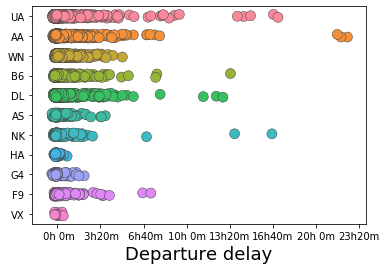

In [26]:
ax3 = sns.stripplot(y="mkt_carrier", x="dep_delay", size=10, data=flights_df, linewidth = 0.5)
plt.setp(ax3.get_xticklabels(), fontsize=10)
plt.setp(ax3.get_yticklabels(), fontsize=10)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18)
ax3.yaxis.label.set_visible(False)

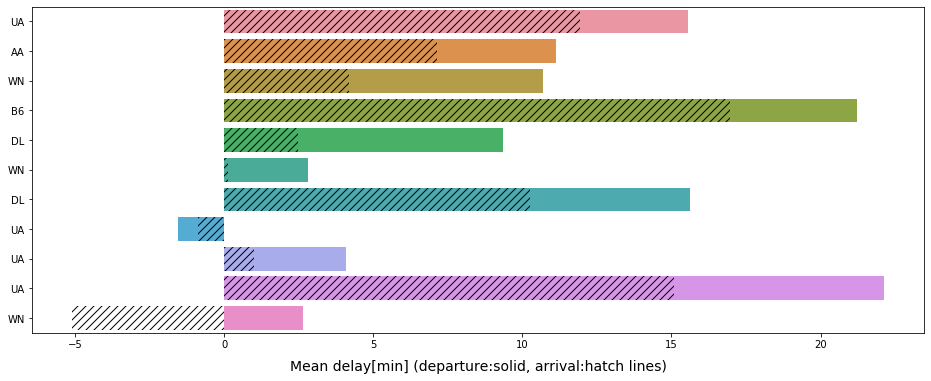

In [27]:
fig = plt.figure(1, figsize=(16,6))
ax = sns.barplot(x="dep_delay", y="mkt_carrier", data=flights_df, ci=None)
ax = sns.barplot(x="arr_delay", y="mkt_carrier", data=flights_df, color="r", hatch = '///', alpha = 0.0, ci=None)

ax.set_yticklabels(flights_df['mkt_carrier'])
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay[min] (departure:solid, arrival:hatch lines)',
           fontsize=14, labelpad=10);

#### Regression
The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights 1 week in advance.

In [289]:
flights_df['label'] = (flights_df.arr_delay >= 0).astype('int')

In [290]:
def prevalence (y_actual):
    return (sum(y_actual)/len(y_actual))

In [291]:
print ('prevalence %.3f'%prevalence(flights_df['label'].values))

prevalence 0.371


In [292]:
#feature = feature_cols
X = flights_df # Features reshape
y = flights_df.label

In [236]:
#X = flights_df[feature_cols].values.reshape(-1, 1) # Features reshape
#y = flights_df.arr_delay.values.reshape(-1,1)

In [293]:
X_train, X_test,y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.3, random_state=1)

In [321]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [238]:
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

In [294]:
#Linear Regression
regr = LinearRegression()
regr.fit(X_train, y_train)
# make predictions
y_pred = regr.predict(X_test)

In [295]:
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 -2.2221113837872508e-13
Coefficients: 
 [ 9.38143248e-21 -4.61870125e-17  4.68036525e-17 -3.82181266e-18
  7.77237432e-18 -4.26578303e-14  4.26308874e-14  1.47659662e-14
  4.24852296e-14 -4.26143656e-14  1.30173823e-16 -6.14786000e-15
  1.41539205e-18  3.47550324e-17 -4.32124446e-18 -1.31842796e-16
 -7.21912112e-16  5.66207644e-17  1.93310680e-16 -1.54675601e-16
 -1.34667087e-15 -4.40036792e-17 -1.32616984e-16  3.93474677e-16
 -3.00145728e-17  6.87060187e-17  8.86799151e-16 -1.74659608e-16
 -8.08149407e-16 -1.54502075e-16 -3.50619031e-18 -3.59293323e-16
  5.57477494e-16  2.86483581e-16 -4.65743104e-16 -1.06707705e-18
 -9.12294718e-17  1.00000000e+00]


In [296]:
print(X.shape, y.shape)

(9796, 38) (9796,)


In [323]:
sgdc = SGDClassifier(loss = 'log', alpha = 0.1)
sgdc.fit(X_train, y_train)

SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [297]:
logreg = LogisticRegression(solver='lbfgs', max_iter=500)

logreg.fit(X_train,y_train)
#
y_pred=logreg.predict(X_test)

In [326]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [335]:
print(confusion_matrix(y_test, y_pred))

[[1812    0]
 [1127    0]]


In [299]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [300]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.0
Mean Squared Error: 0.0
Root Mean Squared Error: 0.0


In [328]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [329]:
y_pred = svclassifier.predict(X_test)

In [309]:
#XGBoost 
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [310]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [311]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [339]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

In [340]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.266090


In [341]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [342]:
print((cv_results["test-rmse-mean"]).head())

0    0.474801
1    0.463013
2    0.431855
3    0.389374
4    0.359864
Name: test-rmse-mean, dtype: float64


In [343]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

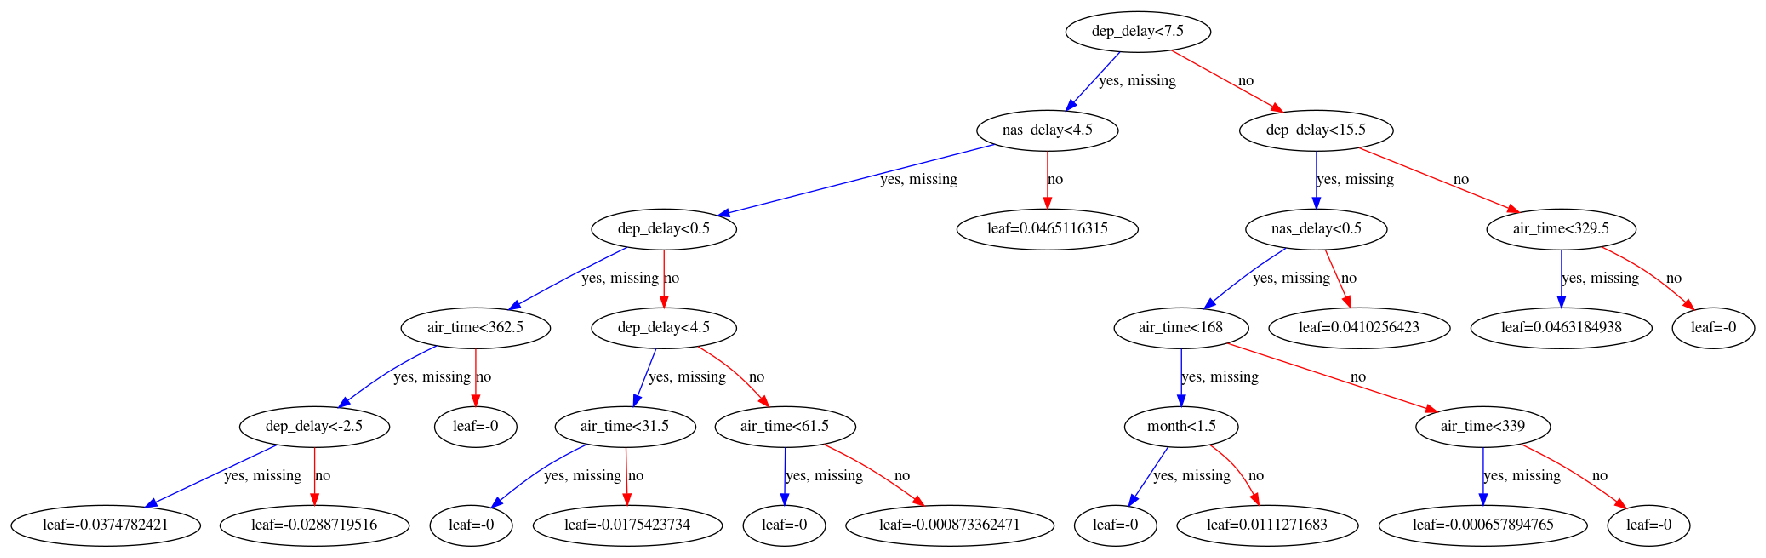

In [345]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

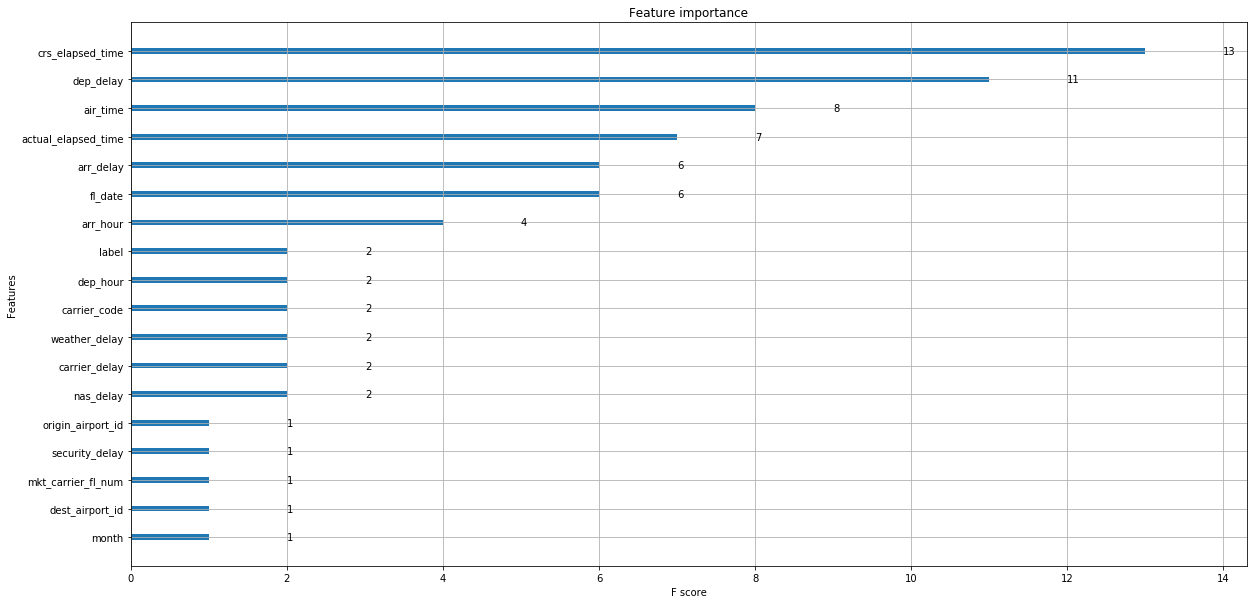

In [349]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [30, 10]
plt.show()

In [327]:
#plt.scatter(X, y)
#plt.plot(X, y_pred, color='red')
#plt.show()

In [319]:
#PCA
x = StandardScaler().fit_transform(X_train)
np.mean(x), np.std(x)

(9.705818632060568e-15, 0.9733285267845752)

In [320]:
X = x
Y = y_train
# feature extraction
pca = PCA(n_components=0.95)
fit = pca.fit(X)
pc_flights = pca.fit_transform(X)
# summarize components
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance: [0.13170777 0.10647015 0.0741468  0.05850109 0.05543934 0.05414217
 0.05133406 0.0454542  0.04077352 0.04000686 0.03785466 0.03723278
 0.03651943 0.03277868 0.02859452 0.02790803 0.02762945 0.02666628
 0.02524234 0.02366378]
[[ 1.98749033e-03 -2.50058633e-01 -2.50045295e-01  4.64042224e-02
   4.28567496e-02  7.72671503e-03  6.02934680e-03 -6.93889390e-18
   4.33507676e-01  4.32764849e-01  4.36071860e-01 -3.38813179e-21
   4.36523705e-01  5.24465053e-03  3.46462274e-04  2.90257621e-02
   5.19816638e-03 -5.72631233e-03 -3.11254749e-03  5.60738823e-03
   3.17698688e-02 -4.99418404e-03  4.36887727e-02 -9.90397270e-03
  -1.18446708e-01  4.79443723e-02  8.24366855e-02  1.98352088e-01
  -2.13924448e-01  1.81954523e-03  1.56517528e-02 -1.21355546e-02
  -5.63529150e-03 -2.84081390e-02  1.08967162e-02  1.99772609e-02
  -1.39319778e-03  3.05694383e-02]
 [ 5.68798354e-03  2.93006111e-02  2.93371061e-02 -2.27762870e-03
  -1.38199056e-02  4.34371745e-01  4.55834637e-01  2.7755575

In [333]:
principal_flights_df = pd.DataFrame(data = pc_flights, 
                                    columns = ['component 1', 'component 2', 'component 3',
                                               'component 4', 'component 5', 'component 6',
                                               'component 7', 'component 8', 'component 9'])
principal_flights_df

IndentationError: unexpected indent (<ipython-input-333-96c553f7b462>, line 2)

/home/jewelle/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


NameError: name 'principal_flights_df' is not defined

<Figure size 3600x720 with 0 Axes>

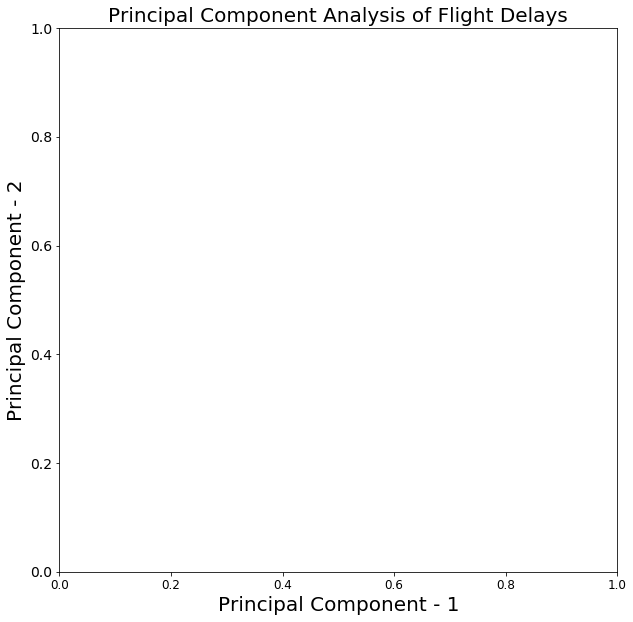

In [331]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Flight Delays",fontsize=20)
targets = ['Target Variable']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = flights_df['label'] == target
    plt.scatter(principal_flights_df.loc[indicesToKeep, 'principal component 1']
               , principal_flights_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

Feature Selection / Dimensionality Reduction

In [1]:
X = X_train[::]
Y = Y_train.arr_delay
# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, Y)
print(model.feature_importances_)

NameError: name 'delays' is not defined